# 图像增广

- 大型数据集是成功应用深度神经网络的先决条件。
- 图像增广在对训练图像进行一系列的随机变化之后，生成相似但是不同的训练样本，从而扩大了训练集的规模。
- 随机改变训练样本可以减少模型对某些特征的依赖，从而提高泛化能力。
- 可以裁剪、翻转、调整亮度、颜色等因素
- 图像增广技术对于AlexNet的成功是必不可少的。


In [56]:
%matplotlib inline
import torch as t 
import torchvision
import sys
sys.path.append("../")
from pltutils import *


In [57]:
set_figsize()
import PIL.Image as Image
img = Image.open("../figures/cat.jpg")

(575, 663)


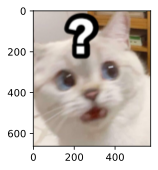

In [58]:
plt.imshow(img)
print(img.size)

In [59]:
def apply(img:Image,aug,num_rows=2,num_cols=4,scale=1.5):
    Y = [ aug(img) for _ in range(num_rows*num_cols)]
    show_images(Y, num_rows, num_cols, scale=scale)

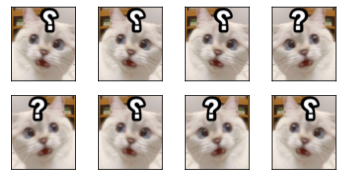

In [60]:
apply(img, torchvision.transforms.RandomHorizontalFlip())


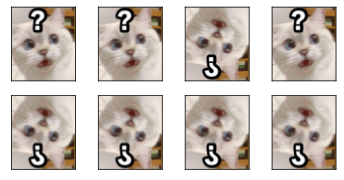

In [61]:
apply(img,torchvision.transforms.RandomVerticalFlip())

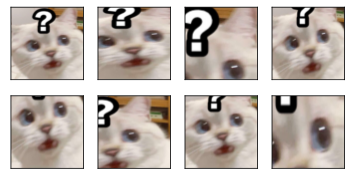

In [62]:
shape_aug = torchvision.transforms.RandomResizedCrop((300,300),scale=(0.1,1),ratio=(0.5,2))
apply(img,shape_aug)

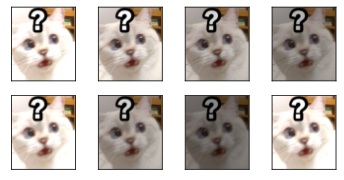

In [63]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))


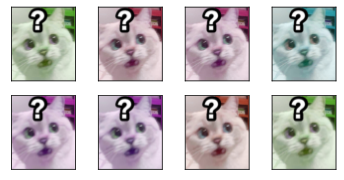

In [64]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

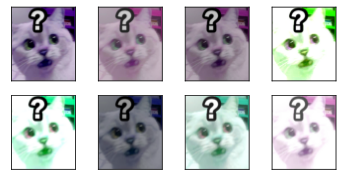

In [65]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5))


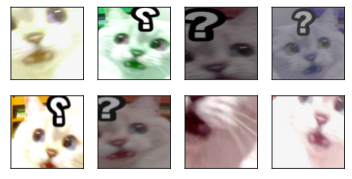

In [66]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
augs =torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),color_aug,shape_aug])
apply(img,augs)

In [67]:
aug2 = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
])

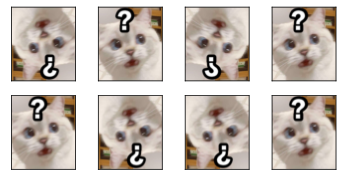

In [68]:
apply(img,aug2)

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

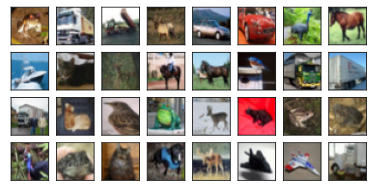

In [69]:
all_imgs= torchvision.datasets.CIFAR10(train=True,root="../dataset",download=True)
show_images([all_imgs[i][0] for i in range(32)],4,8,scale=0.8)


In [70]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [71]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../dataset", train=is_train,
                                           transform=augs, download=False)
    dataloader = t.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=is_train, num_workers=0)
    return dataloader


In [75]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save


def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=[t.device("cuda:0")]):
    """用多GPU进行模型训练"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')


In [78]:
batch_size, devices, net = 256, [
    t.device("cuda:0")], torchvision.models.resnet18()


def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)


net.apply(init_weights)


def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)


loss 0.425, train acc 0.850, test acc 0.668
5282.5 examples/sec on [device(type='cuda', index=0)]


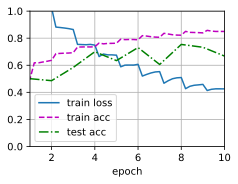

In [79]:
train_with_data_aug(train_augs, test_augs, net)
